In [1]:
%pylab
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1,'../src')
sys.path.insert(1,'../')

matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']
from __future__ import print_function
import timeit
from ellipsoid import *

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


### Test distribution

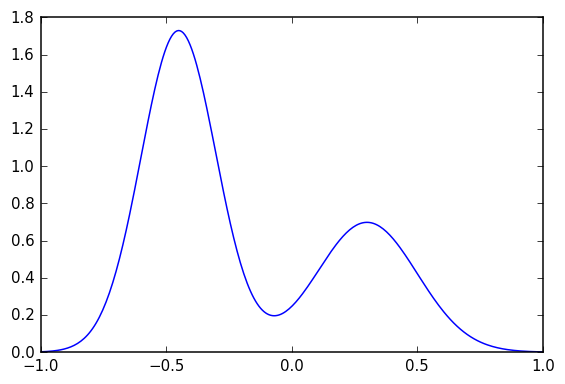

In [2]:
mixture_params = ((.65, -.45, .15), (.35, .3, .2))
distribution = mixture_distribution([normal_distribution(-.45, .15), normal_distribution(.3, .2)], [.65, .35])
fig = plot_distribution(distribution, (-1, 1))

### We draw samples

In [3]:
n = 10000
samples = sorted(distribution.draw_samples(n))

smin = np.min(samples) - 1e-3
smax = np.max(samples) + 1e-3
print('n = {}  min = {}  max = {}'.format(n, np.min(samples), np.max(samples)))

n = 10000  min = -0.98776172311  max = 1.02275628571


The plot only shows a subset of the samples.

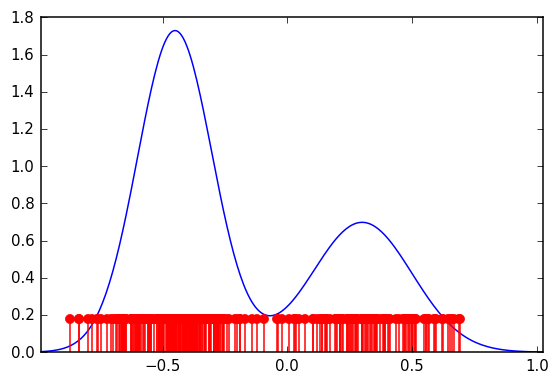

In [4]:
fig = plot_distribution_with_samples(distribution, np.random.choice(samples, 300), (smin, smax))

### Let's run our algorithm

In [5]:
# Number of pieces
t = 5

# Rough estimate of eps to get the number of initial intervals
eps = math.sqrt(2 * t / float(n))
num_initial_intervals = min(n, int(math.ceil(10.0 * t / eps)))

num_merged_intervals_holdout = t
max_final_num_intervals = 2 * num_merged_intervals_holdout + 1

print('num_initial_intervals = {}  max_final_num_intervals = {}  eps = {}'.format(num_initial_intervals, max_final_num_intervals, eps))

# Parameters for the A1 projections
h = ellipsoid_cpp.LinearPieceVector()
samples_cpp = ellipsoid_cpp.DoubleVector(samples)
opts = ellipsoid_cpp.A1ProjectionOptions()
opts.max_gap = eps / (20.0 * max_final_num_intervals)
opts.max_num_iterations = 100
opts.num_initial_interval_levels = 2
stats = ellipsoid_cpp.A1ProjectionStats()
print('opts.max_gap = {}  opts.max_num_iterations = {}\n'.format(opts.max_gap, opts.max_num_iterations))

# Actually running the algorithm
%timeit ellipsoid_cpp.piecewise_linear_approx(samples_cpp, smin, smax, num_initial_intervals, num_merged_intervals_holdout, max_final_num_intervals, opts, h, stats)
print('\nnum_merging_iterations = {}  num_a1_projections = {}'.format(stats.num_merging_iterations,  stats.num_a1_projections))
print('num_a1_computations = {}  weighted_num_a1_computations = {}'.format(stats.num_a1_computations,  stats.weighted_num_a1_computations))

res = convert_piecewise_linear_to_pp_hypothesis(h)
l1_err = compute_l1_quad(distribution.get_pdf(), get_ppoly_pdf(res), (smin, smax))
print('\nL1 error: {}'.format(l1_err))

num_initial_intervals = 1582  max_final_num_intervals = 11  eps = 0.0316227766017
opts.max_gap = 0.000143739893644  opts.max_num_iterations = 100

10 loops, best of 3: 111 ms per loop

num_merging_iterations = 11  num_a1_projections = 131528
num_a1_computations = 7120  weighted_num_a1_computations = 43.0071

L1 error: 0.0412759820243


How many samples do we need to get this accuracy according to our prediction? $\frac{t}{\varepsilon^2}$ is

In [6]:
4 * t / l1_err**2

11739.109843881481

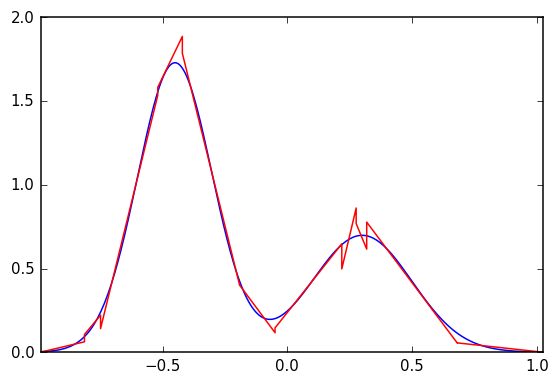

In [7]:
fig = plot_distribution(distribution, (smin, smax))
fig = poly_plot([res], (smin, smax), fig, ['red'])